# Import

In [1]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers

In [2]:
# Datasets import
y = scipy.io.loadmat('y_SL.mat')
y = y.get('y')
x = scipy.io.loadmat('x_SL.mat')
x = x.get('x')

# Preprocessing

In [7]:
# Datasets import
delete=np.argwhere(y[:,1]>3)
y = np.delete(y,delete[:,0],axis=0)
x = np.delete(x,delete[:,0],axis=0)

In [8]:
# Convert the first column to integers values. The first column of labels are the foot side, "0" for right, "1" for left
y_class=y[:,0].astype(int)

In [9]:
Acc_range=16
Gyr_range=2000

# Scale the samples from 0 to 1
x[:,:,0:3] = x[:,:,0:3] / (Acc_range*2*9.81) + 0.5
x[:,:,3:6] = x[:,:,3:6]/ (Gyr_range*2) + 0.5
x[:,:,6:9] = x[:,:,6:9] / (Acc_range*2*9.81) + 0.5
x[:,:,9:12] = x[:,:,9:12]/ (Gyr_range*2) + 0.5

In [10]:
# Function to split a portion of data from the dataset and create a train and a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Keras sequential

In [12]:
input_shape = x_train.shape[1:]

Classification

In [17]:
# Classification model building
model = tf.keras.models.Sequential([
                    keras.Input(shape=input_shape),
                    layers.Flatten(),
                    layers.Dense(2, activation='softmax')
                                  ])

In [18]:
# Model compilation
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [19]:
# Fit the model to the train dataset
history = model.fit(x_train, y_train[:,0], epochs=30, validation_split=0.2)

Epoch 1/30


45/45 [==============================] - 1s 7ms/step - loss: 0.4995 - accuracy: 0.8229 - val_loss: 0.2556 - val_accuracy: 0.9831
Epoch 2/30
45/45 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9908 - val_loss: 0.1342 - val_accuracy: 0.9803
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9901 - val_loss: 0.0993 - val_accuracy: 0.9831
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.9908 - val_loss: 0.0910 - val_accuracy: 0.9803
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.9908 - val_loss: 0.0794 - val_accuracy: 0.9831
Epoch 6/30
45/45 [==============================] - 0s 4ms/step - loss: 0.0573 - accuracy: 0.9908 - val_loss: 0.0756 - val_accuracy: 0.9803
Epoch 7/30
45/45 [==============================] - 0s 4ms/step - loss: 0.0517 - accuracy: 0.9908 - val_loss: 0.0734 - val_accuracy: 0.9803
Epoch 8/30
45/45 [=============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


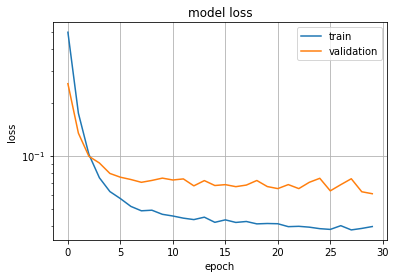

In [20]:
# Show the history of the loss parameters over each epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.yscale('log')
plt.grid()
plt.show()

In [21]:
# Make predictions on the test set
pred=model.predict(x_test)

# Show the eaccuracy of the model
test_loss, test_acc = model.evaluate(x_test, y_test[:,0], verbose=2)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

14/14 [==============================] - 0s 1ms/step
14/14 - 0s - loss: 0.0302 - accuracy: 0.9955 - 41ms/epoch - 3ms/step
Test loss: 0.03019736148416996
Test accuracy: 0.9954853057861328


In [ ]:
# output mat file
import scipy.io as sio
outdict={"y_test_c":y_test[:,0],"y_pred_c":pred}
sio.savemat('y_pred_SLc.mat', outdict)

# Regression

In [23]:
# Create a copy of the dataset
x_train_regr = x_train
x_test_regr  = x_test

# Take only the labels in the second column, the stride length
y_train_regr = y_train[:,1]
y_test_regr  = y_test[:,1]

Swap features when needed

In [24]:
# Swap of the columns based on the first column of the labels, which is equal to "0" if the lift off foot is the right one 
for i in range(1,len(x_train_regr)):
  if y_train[i,0]==0:
    x_train_regr[i,:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]] = x_train_regr[i,:,[6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5]]
for i in range(1,len(x_test_regr)):
  if pred[i]==False:
    x_test_regr[i,:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]  = x_test_regr[i,:,[6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5]]

In [27]:
input_shape = [50,12,1]

# Model building
model_0 = tf.keras.models.Sequential([
          keras.Input(shape=input_shape),
          tf.keras.layers.Conv2D(32, kernel_size= (8,1), activation= 'relu', padding= 'SAME'),
          tf.keras.layers.Conv2D(64, kernel_size= (4,1), activation='relu', padding= 'SAME'),
          tf.keras.layers.MaxPooling2D(pool_size= (2,1), strides= (2,1), padding= 'SAME'),
          layers.Dropout(0.5, noise_shape=[None,1,12,64], seed= 42),
          layers.Flatten(),
          layers.Dense(256, activation= 'relu'),
          layers.Dropout(0.1, seed= 42),
          layers.Dense(1)
                        ])

In [29]:
# Model compilation
model_0.compile(optimizer='nadam',
                loss=tf.keras.losses.MeanAbsoluteError(reduction="auto"),
               )

In [30]:
# Define a checkpoint for the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

# Fit the model to the train dataset
history_0 = model_0.fit(x_train_regr, y_train_regr, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb])

# Reload the best model
model = keras.models.load_model("best_model.h5")

Epoch 1/100


45/45 [==============================] - 5s 87ms/step - loss: 0.4520 - val_loss: 0.1899
Epoch 2/100
 1/45 [..............................] - ETA: 3s - loss: 0.2172

c:\Users\mercu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 4s 85ms/step - loss: 0.2135 - val_loss: 0.1050
Epoch 3/100
45/45 [==============================] - 4s 84ms/step - loss: 0.1803 - val_loss: 0.1016
Epoch 4/100
45/45 [==============================] - 4s 85ms/step - loss: 0.1700 - val_loss: 0.0938
Epoch 5/100
45/45 [==============================] - 4s 83ms/step - loss: 0.1661 - val_loss: 0.1034
Epoch 6/100
45/45 [==============================] - 4s 89ms/step - loss: 0.1607 - val_loss: 0.2704
Epoch 7/100
45/45 [==============================] - 4s 86ms/step - loss: 0.1600 - val_loss: 0.1317
Epoch 8/100
45/45 [==============================] - 4s 88ms/step - loss: 0.1492 - val_loss: 0.0823
Epoch 9/100
45/45 [==============================] - 4s 90ms/step - loss: 0.1491 - val_loss: 0.0724
Epoch 10/100
45/45 [==============================] - 4s 87ms/step - loss: 0.1516 - val_loss: 0.0916
Epoch 11/100
45/45 [==============================] - 4s 87ms/step - loss: 0.1449 - val_loss: 0.0859
Epoch 12/1

In [31]:
# Print the MAE on the validation set
print('Min val_loss: '+str(min(history_0.history['val_loss'])))

Min val_loss: 0.06377989053726196


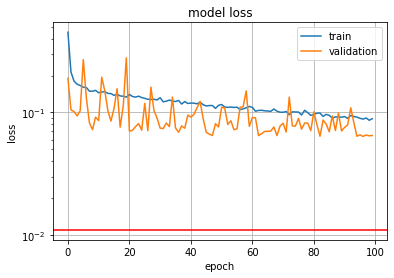

In [32]:
# Show the history of the loss parameters over each epochs
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.axhline(y=0.011, color='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.yscale('log')
plt.grid()
plt.show()

In [33]:

# Sort the sample according to labels ascending order
ind = np.argsort( y_test_regr[:] )
y_test_sorted = y_test_regr[ind]
x_test_sorted = x_test_regr[ind]

# Make predictions on the test set
pred_0=model_0.predict(x_test_sorted)

14/14 [==============================] - 0s 8ms/step


0.060768022730067865


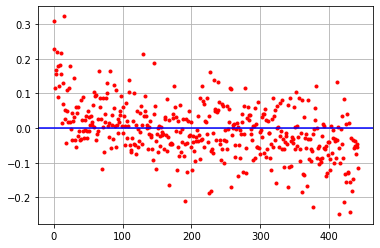

In [34]:
# MAE of the test set
print(np.mean(np.abs(pred_0[:,0]-y_test_sorted)))

# Show predictions and labels
plt.plot(pred_0[:,0]-y_test_sorted,'r.')
plt.axhline(y=0, color='b')
plt.grid()

In [35]:
# output mat file
import scipy.io as sio
outdict={"y_test":y_test_sorted,"y_pred":pred_0[:,0]}
sio.savemat('y_pred_SL.mat', outdict)